In [1]:
#import libraries and data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import cufflinks as cf
from warnings import filterwarnings
from nltk import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier

train_data = pd.read_csv('EXIST2021_training.tsv', sep="\t")
test_data = pd.read_csv('EXIST2021_test_labeled.tsv', sep="\t")

#wordcloud visualization
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import urllib
import requests

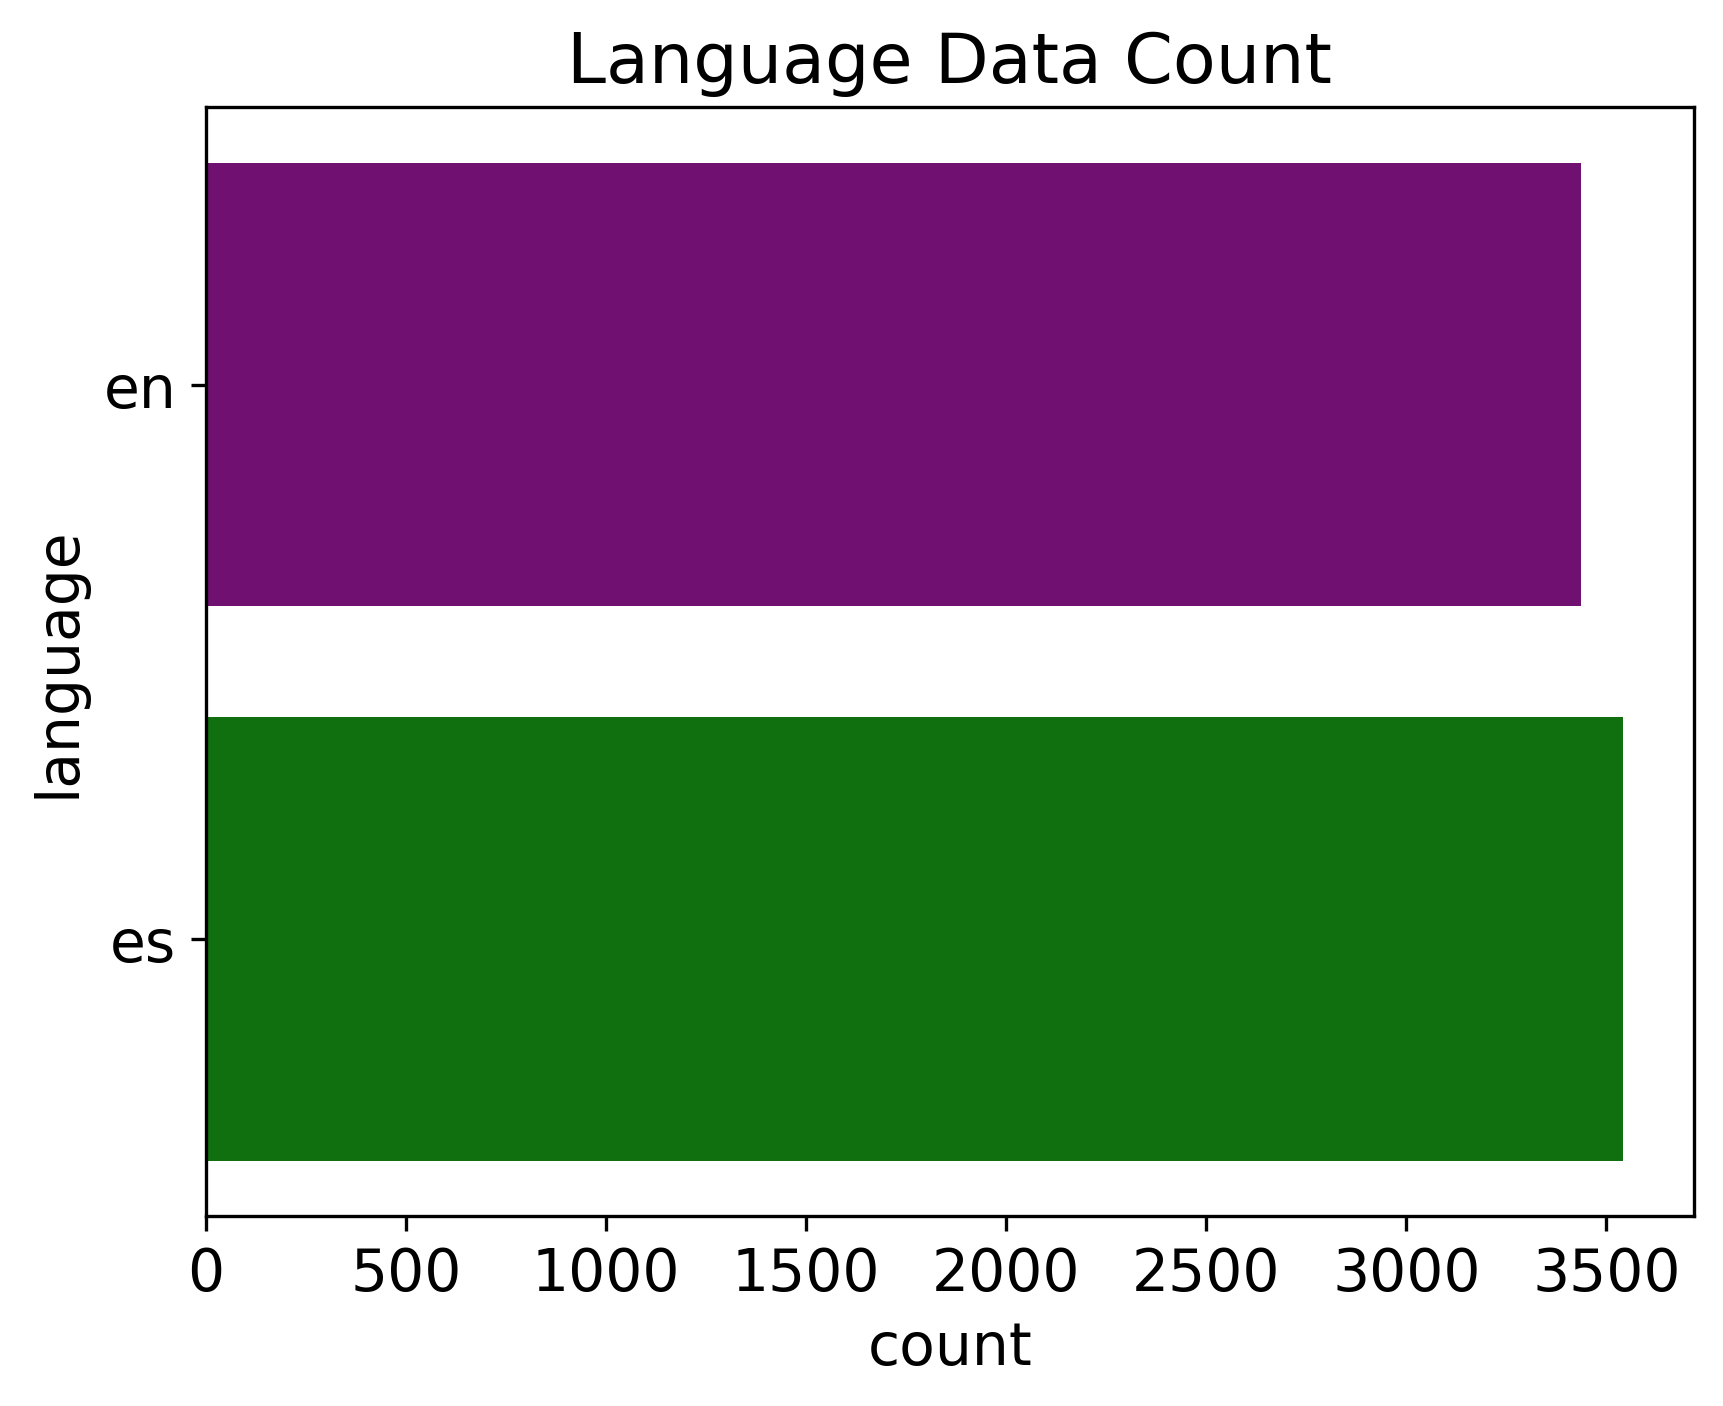

In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'font.size': 14})
#graph of spanish vs. english count
custom_palette = ['purple', 'green']
sns.set_palette(custom_palette)
fig1 = sns.countplot(y = 'language', data = train_data)
plt.title('Language Data Count')
plot = fig1.get_figure()

In [11]:
#remove user and some columns
train_clean_data = train_data.drop(columns=['test_case', 'id', 'source', 'task2'])
test_clean_data = test_data.drop(columns=['test_case', 'id', 'source', 'task2'])

#taken from online
def remove_users(text, pattern):
    
    r = re.findall(pattern, text)
    
    for i in r:
        text = re.sub(i,"",text)
        
    return text

train_clean_data['cleantext'] = np.vectorize(remove_users)(train_clean_data['text'], "@[\w]*")
test_clean_data['cleantext'] = np.vectorize(remove_users)(test_clean_data['text'], "@[\w]*")

In [12]:
#text to lowercase and remove punctaution and links

train_clean_data['cleantext'] = train_clean_data['cleantext'].apply(str.lower)
train_clean_data['cleantext'] = train_clean_data['cleantext'].str.replace(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", regex = True)

test_clean_data['cleantext'] = test_clean_data['cleantext'].apply(str.lower)
test_clean_data['cleantext'] = test_clean_data['cleantext'].str.replace(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", regex = True)

In [13]:
#removing stopwords
import nltk.corpus
from nltk.corpus import stopwords
stop = stopwords.words(fileids=('english', 'spanish'))

train_clean_data['cleantext'] = train_clean_data['cleantext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_clean_data['cleantext'] = test_clean_data['cleantext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [14]:
#split by language, all english
train_engtweets = train_clean_data.loc[train_clean_data['language'] == 'en']
train_engtweets = train_engtweets.drop(columns = ['language', 'text'])

test_engtweets = test_clean_data.loc[test_clean_data['language'] == 'en']
test_engtweets = test_engtweets.drop(columns = ['language', 'text'])

In [15]:
#stemming and lemmatization
train_token_engtweets = train_engtweets['cleantext'].apply(lambda x: x.split())
test_token_engtweets = test_engtweets['cleantext'].apply(lambda x: x.split())

ps = PorterStemmer()
wnl = WordNetLemmatizer()

train_token_engtweets = train_token_engtweets.apply(lambda x: [wnl.lemmatize(i) if wnl.lemmatize(i).endswith('e') else ps.stem(i) for i in x])
test_token_engtweets = test_token_engtweets.apply(lambda x: [wnl.lemmatize(i) if wnl.lemmatize(i).endswith('e') else ps.stem(i) for i in x])

#recombine tokens
for i in range(len(train_token_engtweets)):
    train_token_engtweets[i] = ' '.join(train_token_engtweets[i])
    
train_engtweets['cleantext'] = train_token_engtweets

for i in range(len(test_token_engtweets)):
    test_token_engtweets[i] = ' '.join(test_token_engtweets[i])
    
test_engtweets['cleantext'] = test_token_engtweets

In [16]:
#word2vec stuff
sentences = [sentence.split() for sentence in train_engtweets['cleantext']]
w2v_model = Word2Vec(sentences, vector_size=100, window=7, min_count=2, workers=4, sg=1, hs=1, epochs=5, negative=5)

In [17]:
#more word2vec
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_engtweets = np.array([vectorize(sentence) for sentence in train_engtweets['cleantext']])
X_test_engtweets = np.array([vectorize(sentence) for sentence in test_engtweets['cleantext']])

In [18]:
#y data
Y_train_engtweets = train_engtweets['task1']
Y_test_engtweets = test_engtweets['task1']

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

model = LogisticRegression(
    C=100, penalty='l2', solver='liblinear'
)

model.fit(X_train_engtweets, Y_train_engtweets)

LogisticRegression(C=100, solver='liblinear')

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test_engtweets)
print('Accuracy:', accuracy_score(Y_test_engtweets, y_pred))
print('Precision:', precision_score(Y_test_engtweets, y_pred, pos_label='sexist'))
print('Recall:', recall_score(Y_test_engtweets, y_pred, pos_label='sexist'))
print('F1 score:', f1_score(Y_test_engtweets, y_pred, pos_label='sexist'))

Accuracy: 0.6644021739130435
Precision: 0.7142857142857143
Recall: 0.6001727115716753
F1 score: 0.652275926794932


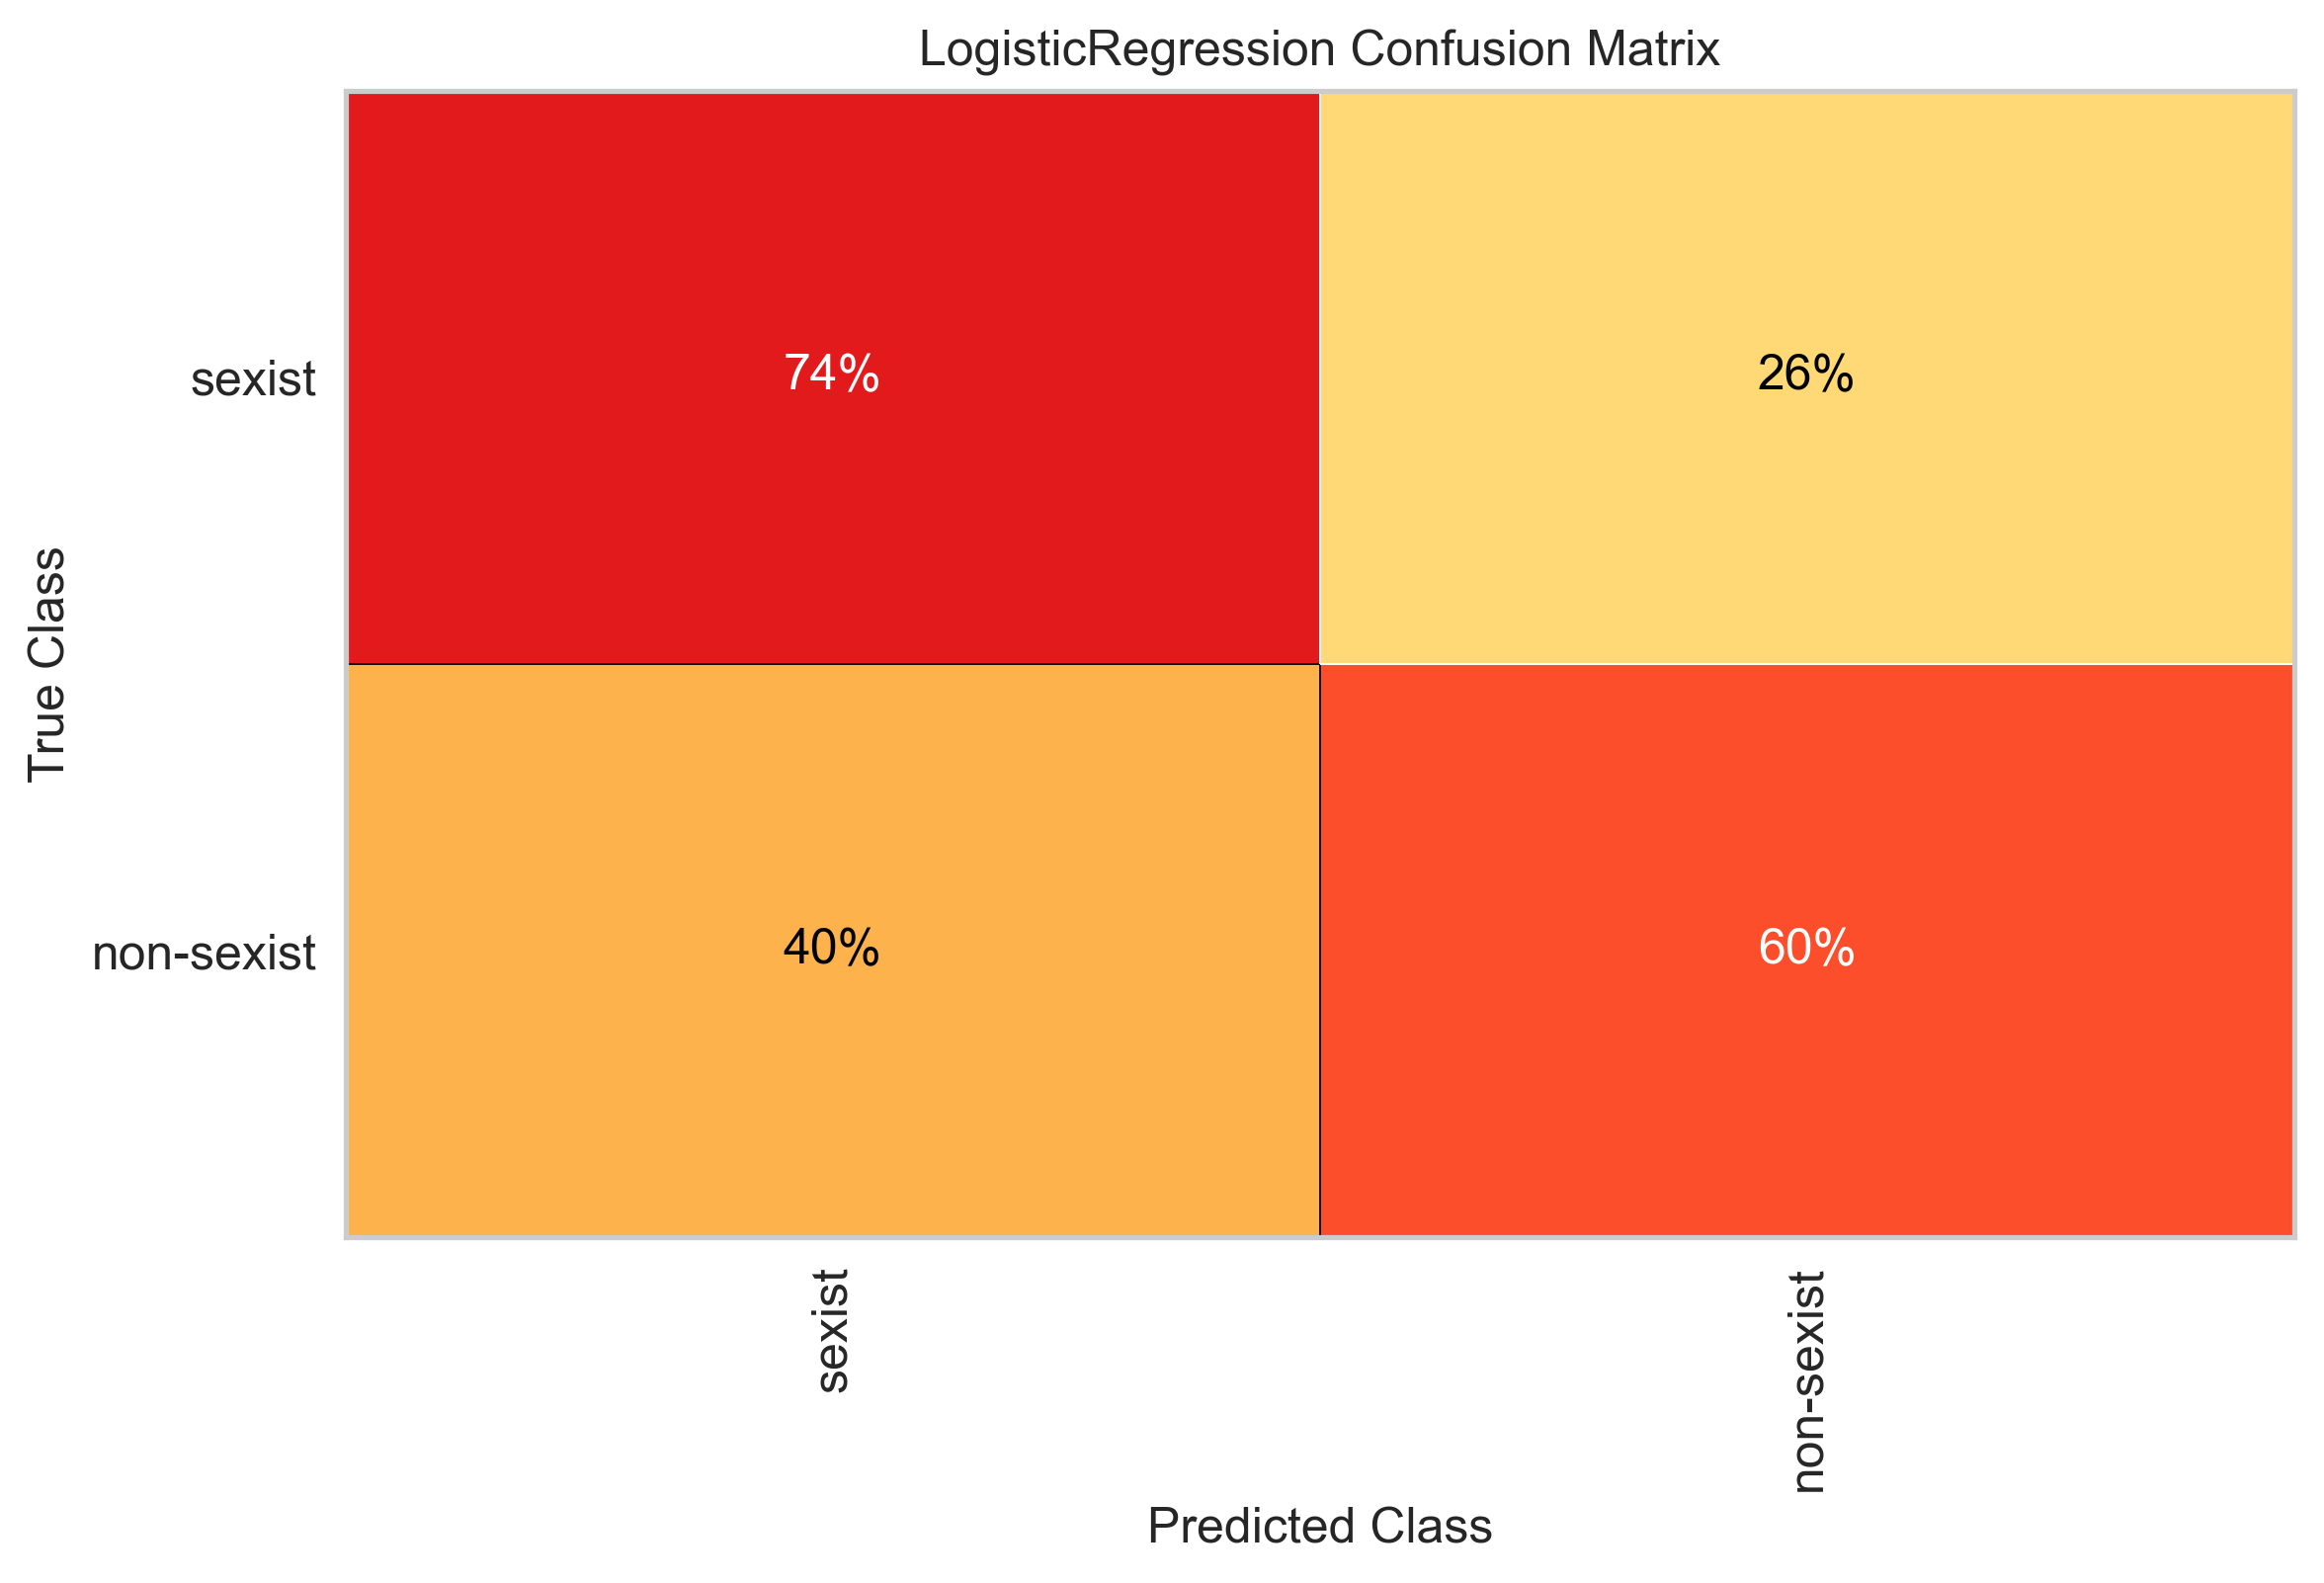

In [25]:
classes = ['sexist', 'non-sexist']
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(
    model, classes=classes,
    percent=True, label_encoder={0: 'sexist', 1: 'non-sexist'})

cm.fit(X_train_engtweets, Y_train_engtweets)
cm.score(X_test_engtweets, Y_test_engtweets)

cm.show();

for label in cm.ax.texts:
    label.set_size(22)


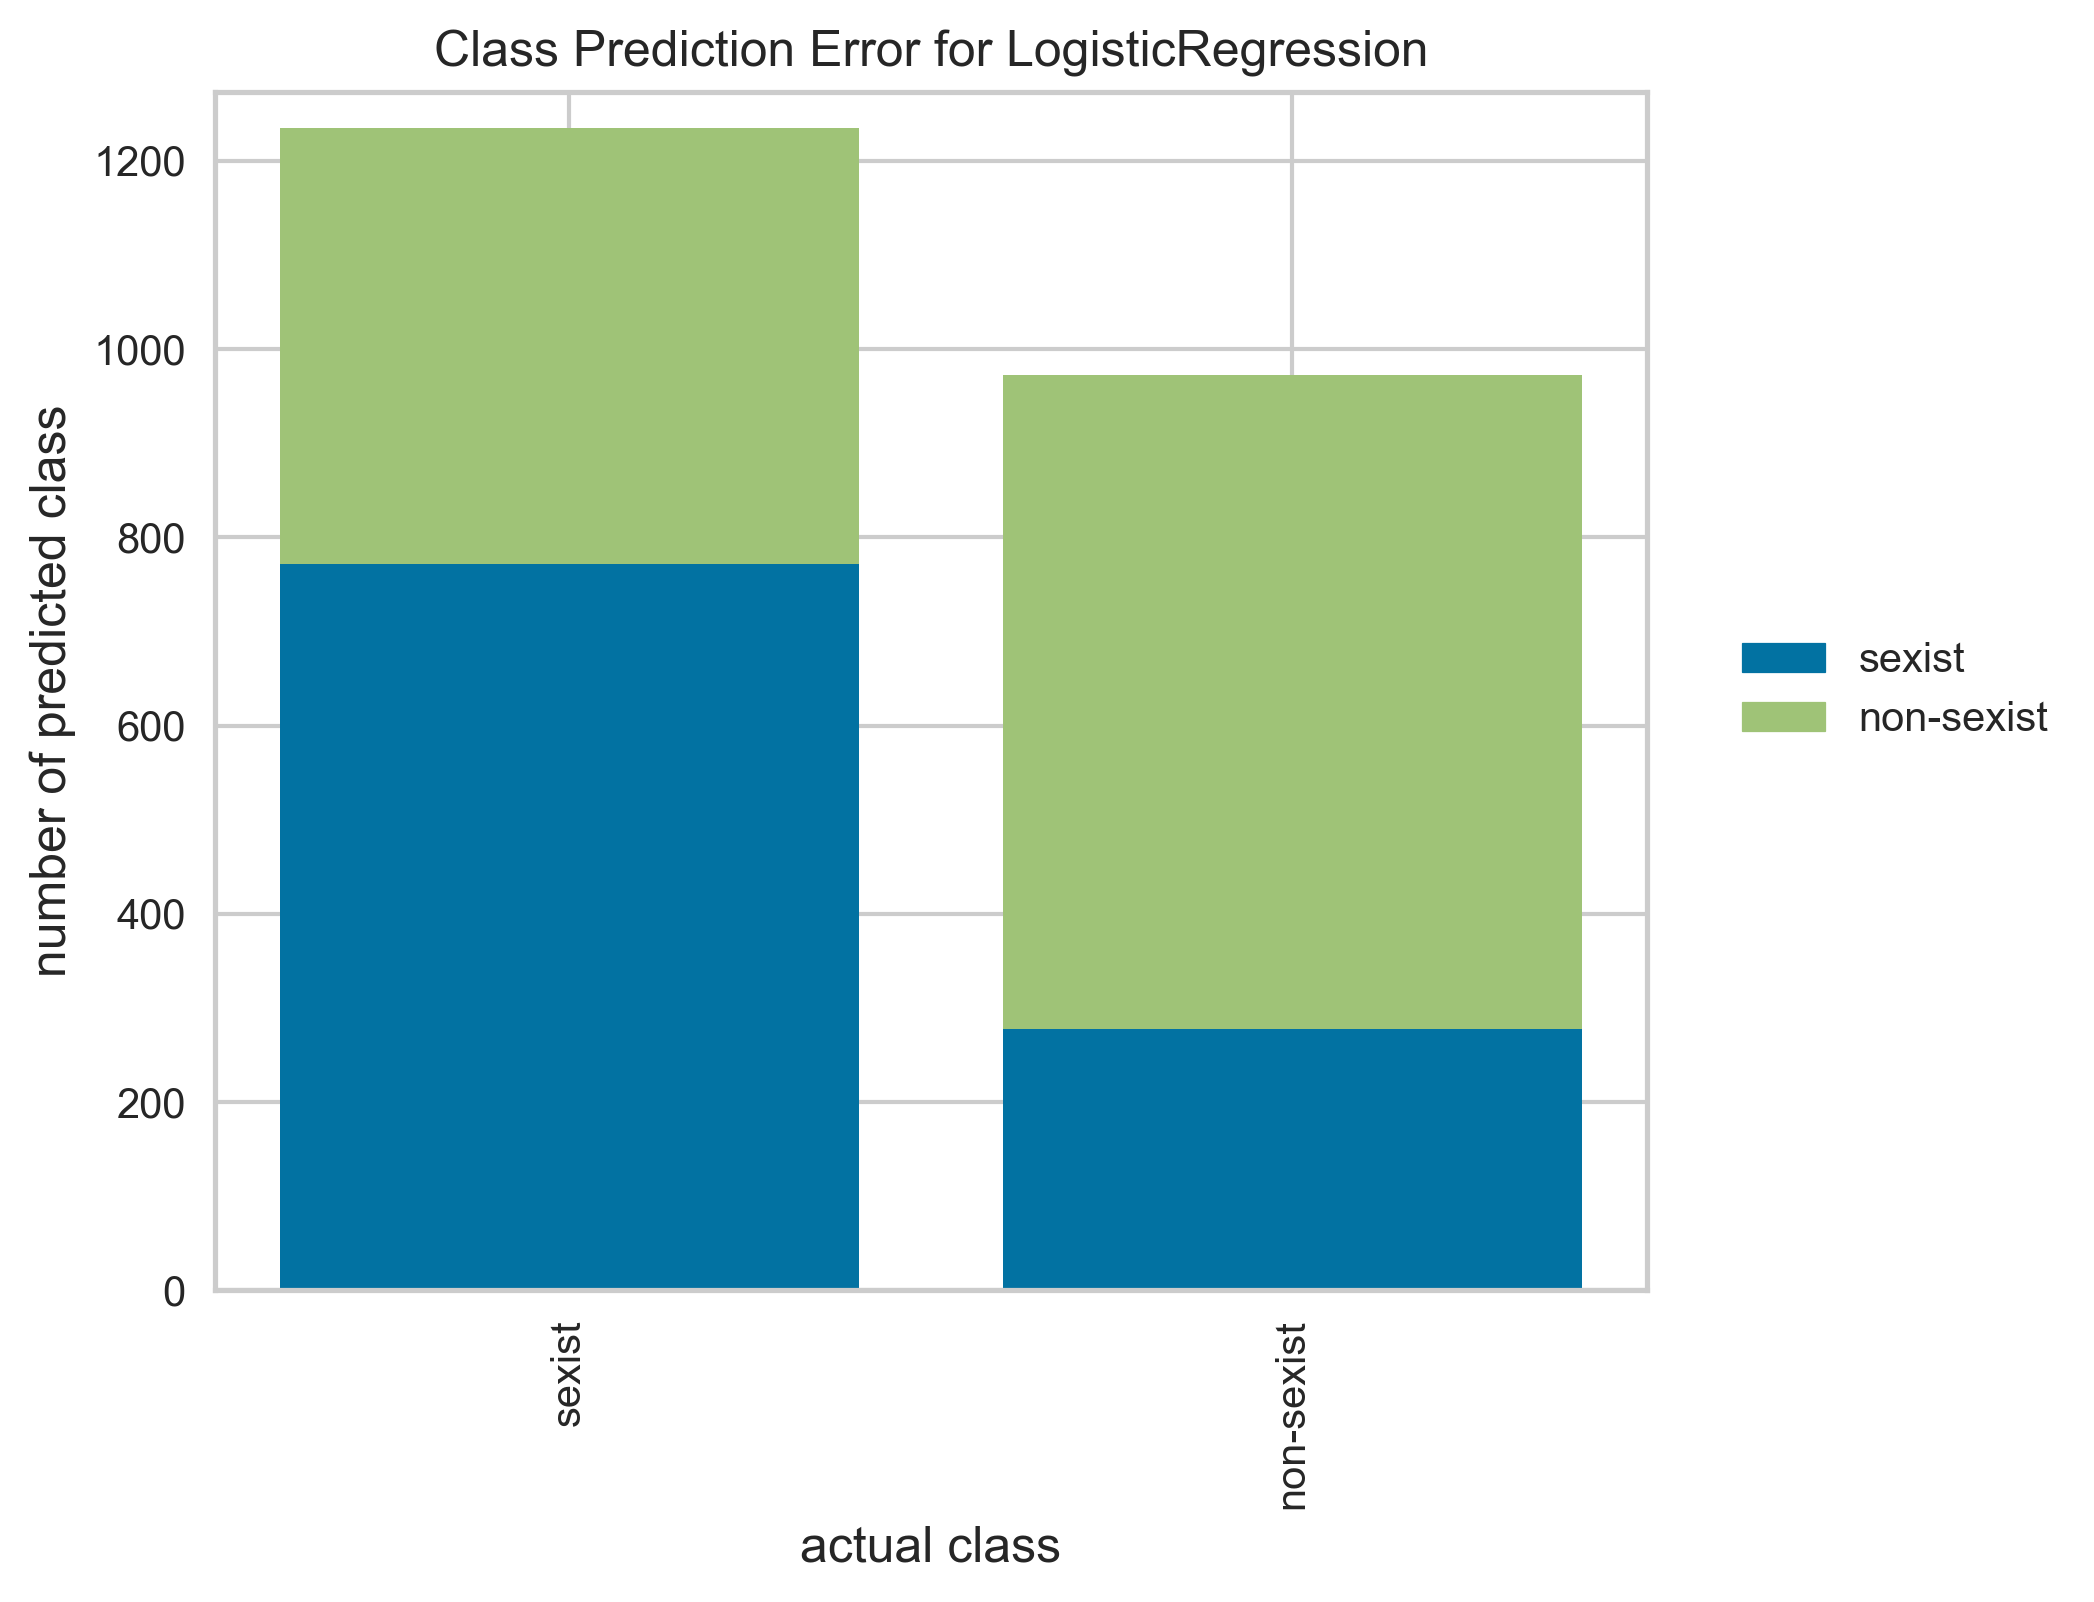

In [22]:
from yellowbrick.classifier import ClassPredictionError
visualizer = ClassPredictionError(
    model, classes=classes)
visualizer.fit(X_train_engtweets, Y_train_engtweets)
visualizer.score(X_test_engtweets, Y_test_engtweets)
visualizer.show();

In [ ]:
model = RandomForestClassifier()
model.fit(X_train_engtweets, Y_train_engtweets)

In [ ]:
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_engtweets, Y_train_engtweets)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [52]:
y_pred = model.predict(X_test_engtweets)

In [107]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics
cm = confusion_matrix(Y_test_engtweets, y_pred)
print(metrics.classification_report(Y_test_engtweets, y_pred))

              precision    recall  f1-score   support

  non-sexist       0.68      0.76      0.71      1050
      sexist       0.75      0.67      0.71      1158

    accuracy                           0.71      2208
   macro avg       0.71      0.71      0.71      2208
weighted avg       0.72      0.71      0.71      2208



In [109]:
accuracy_score(Y_test_engtweets, y_pred)

0.7119565217391305

In [54]:
precision = precision_score(Y_test_engtweets, y_pred, pos_label='sexist')
recall = recall_score(Y_test_engtweets, y_pred, pos_label='sexist')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==Y_test_engtweets).sum()/len(y_pred), 3)))

Precision: 0.684 / Recall: 0.602 / Accuracy: 0.645
